In [ ]:
!pip install -r requirements.txt
# !CUDA_VISIBLE_DEVICES=0

## 

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

# Set CUDA device explicitly first
torch.cuda.set_device(0)
device = torch.device("cuda:0")
print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model_dir = "Qwen/Qwen3-0.6B"
tokenizer = AutoTokenizer.from_pretrained(model_dir, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_dir,
    quantization_config=bnb_config,   
    device_map={"": torch.cuda.current_device()},  # Explicitly set to current CUDA device
    torch_dtype=torch.bfloat16,
    trust_remote_code=True             
)

model.config.use_cache = False
model.config.pretraining_tp = 1

/local/s3905020/slm-go/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using CUDA device: NVIDIA GeForce RTX 3090


In [2]:
# training prompt
train_prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context. 
Write a response that appropriately completes the request. 
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a cybersecurity expert with advanced knowledge in software security and common weakness enumerations(CWE). 
Look at the following code and classify it with the apropriate CWE's if it has any. 

### Code:
{}

### Response:
{}"""

In [4]:
EOS_TOKEN = tokenizer.eos_token  # Must add EOS_TOKEN

def formatting_prompts_func(examples):
    inputs = examples["input"]
    outputs = examples["output"]
    texts = []
    for code, response in zip(inputs, outputs):
        # Append the EOS token to the response if it's not already there
        if not response.endswith(tokenizer.eos_token):
            response += tokenizer.eos_token
        text = train_prompt_style.format(code, response)
        texts.append(text)
    return {"text": texts}

In [ ]:
# Dataset loading
from datasets import load_dataset

dataset = load_dataset(
    "json",
    data_dir="/local/s3905020/code/dataset-creation"
)["train"]
# Formatting the dataset, create a string from the output field which is a list
dataset = dataset.map(lambda x: {"output": [" ".join(map(str, out)) if isinstance(out, list) else str(out) for out in x["output"]]}, batched=True)
dataset = dataset.map(
    formatting_prompts_func,
    batched=True,
)
dataset["text"][10]

In [ ]:
dataset["text"][100]

In [7]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

In [3]:
inference_prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context. 
Write a response that appropriately completes the request. 
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a cybersecurity expert with advanced knowledge in software security and common weakness enumerations (CWE). 
Please look at the following code and classify it with the appropriate CWE's if it has any.

### Question:
{}

### Response:
<think>

"""


In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

# Use the device that the model was loaded on
device = model.device
print(f"Model is on device: {device}")

# BASE MODEL TESTING
question = dataset[10]['input']
inputs = tokenizer(
    [inference_prompt_style.format(question) + tokenizer.eos_token],
    return_tensors="pt"
).to(device)

outputs = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=1200,
    eos_token_id=tokenizer.eos_token_id,
    use_cache=True,
)
response = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print(response[0].split("### Response:")[1])

model.config.use_cache = False
trainer.train()

In [11]:
from peft import LoraConfig, get_peft_model

# LoRA config
peft_config = LoraConfig(
    lora_alpha=16,                           # Scaling factor for LoRA
    lora_dropout=0.05,                       # Add slight dropout for regularization
    r=64,                                    # Rank of the LoRA update matrices
    bias="none",                             # No bias reparameterization
    task_type="CAUSAL_LM",                   # Task type: Causal Language Modeling
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],  # Target modules for LoRA
)

model = get_peft_model(model, peft_config)

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments


# Training Arguments
training_arguments = TrainingArguments(
    output_dir="output",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    optim="paged_adamw_32bit",
    num_train_epochs=4,
    logging_steps=0.2,
    warmup_steps=10,
    logging_strategy="steps",
    learning_rate=2e-4,
    fp16=False,
    bf16=False,
    group_by_length=True,
    report_to="wandb"
)

# Initialize the Trainer
trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=dataset,
    peft_config=peft_config,
    data_collator=data_collator,
)

In [ ]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()

# Ensure the trainer uses the same device as the model
device = model.device
print(f"Training on device: {device}")

# Check if the model is properly loaded on the expected device
if hasattr(model, 'base_model'):
    print(f"Base model device: {model.base_model.device}")
elif hasattr(model, 'model'):
    print(f"Model's model device: {model.model.device}")

# Make sure all model parts are on the same device
model = model.to(device)

model.config.use_cache = False
trainer.train()

In [ ]:
question = dataset[100]['input']
inputs = tokenizer(
    [inference_prompt_style.format(question) + tokenizer.eos_token],
    return_tensors="pt"
).to("cuda")

outputs = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=1200,
    eos_token_id=tokenizer.eos_token_id,
    use_cache=True,
)
response = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print(response[0])

## QWen 0.6B Evaluation
Below are the cells to be run to evaluate the model on a test batch of data

In [4]:
# Cell 1: Imports for Evaluation
import torch
import json
import argparse
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

In [10]:
# Cell 2: Model Loading Functions
def load_model_and_tokenizer(model_dir="Qwen/Qwen3-0.6B", 
                             checkpoint_path="/local/s3905020/thesis-slm/trial_scripts/qwen/output/checkpoint-4656",
                             device_str="cuda:0"):
    print(f"Loading model from {model_dir} and checkpoint from {checkpoint_path}")
    
    # Configure quantization
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=False,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )
    
    # Set device
    if device_str.startswith("cuda"):
        device_id = int(device_str.split(":")[-1])
        torch.cuda.set_device(device_id)
        print(f"Using CUDA device: {torch.cuda.get_device_name(device_id)}")
    
    device = torch.device(device_str)
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_dir, use_fast=True)
    
    # Load base model with quantization
    base_model = AutoModelForCausalLM.from_pretrained(
        model_dir,
        quantization_config=bnb_config,
        device_map={"": device.index if device.type == "cuda" else "cpu"},
        torch_dtype=torch.bfloat16,
        trust_remote_code=True
    )
    
    # Load the PEFT adapter
    model = PeftModel.from_pretrained(base_model, checkpoint_path)
    model.config.use_cache = True
    model.eval()
    
    return model, tokenizer, device

In [ ]:
# Cell 3: Data Loading and Prompt Functions
def load_test_data(test_file, max_samples=None):
    print(f"Loading test data from {test_file}")
    test_data = []
    with open(test_file, 'r') as f:
        for line in f:
            test_data.append(json.loads(line))
            if max_samples and len(test_data) >= max_samples:
                break
    return test_data

def generate_inference_prompt(code):
    return f"""Below is an instruction that describes a task, paired with an input that provides further context. 
Write a response that appropriately completes the request. 
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a cybersecurity expert with advanced knowledge in software security and common weakness enumerations (CWE). 
Please look at the following code and classify it with the appropriate CWE's if it has any.

### Question:
{code}

### Response:
"""

# Inference Code

In [36]:
def inference_model(model, tokenizer, device, code):
    prompt = generate_inference_prompt(code)
    messages = [{
        "role": "user",
        "content": prompt
    }]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=True,  # Enable thinking mode
    )
    inputs = tokenizer([text], return_tensors="pt").to(device)
    
    outputs = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=32768,
        eos_token_id=tokenizer.eos_token_id,
        use_cache=True, # Enable thinking mode
    )
    
    # Get a random number between 0 and the length of test_data
    print(f"Expected output: {test_data[random_index]['output']}")
    response = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    print(f"Model response: {response[0]}")
    return response[0].split("### Response:")[1].strip()

test_data = load_test_data("/local/s3905020/code/dataset-creation/test.jsonl")
import random
random_index = random.randint(0, len(test_data) - 1)
print(f"Randomly selected test data index: {random_index}")
code = test_data[random_index]['input']
model, tokenizer, device = load_model_and_tokenizer()
print(inference_model(model, tokenizer, device, code))

Loading test data from /local/s3905020/code/dataset-creation/test.jsonl
Randomly selected test data index: 447
Loading model from Qwen/Qwen3-0.6B and checkpoint from /local/s3905020/thesis-slm/trial_scripts/qwen/output/checkpoint-4656
Using CUDA device: NVIDIA GeForce RTX 3090
Expected output: []
Model response: user
Below is an instruction that describes a task, paired with an input that provides further context. 
Write a response that appropriately completes the request. 
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a cybersecurity expert with advanced knowledge in software security and common weakness enumerations (CWE). 
Please look at the following code and classify it with the appropriate CWE's if it has any.

### Question:
<think>
package commands

import (
	"context"
	"errors"
	"fmt"
	"math"
	"sync"
	"sync/atomic"
	"time"

	openfgav1 "github.com/openfga/api/p

In [12]:
# Cell 4: Model Evaluation Function
def evaluate_model(model, tokenizer, test_data, device, output_file="evaluation_results.jsonl"):
    print(f"Evaluating model on {len(test_data)} test samples")
    results = []
    
    for idx, item in enumerate(tqdm(test_data)):
        code = item["input"]
        expected_output = item["output"]
        
        prompt = generate_inference_prompt(code)
        
        inputs = tokenizer([prompt], return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs.input_ids,
                attention_mask=inputs.attention_mask,
                max_new_tokens=1200,
                eos_token_id=tokenizer.eos_token_id,
                use_cache=True,
            )
        
        generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
        response = generated_text.split("### Response:")[1].strip() if "### Response:" in generated_text else generated_text
        
        result = {
            "index": idx,
            "input": code,
            "expected_output": expected_output,
            "model_output": response,
            "full_response": generated_text
        }
        
        results.append(result)
        
        # Save results after each prediction to avoid losing data if the notebook crashes
        with open(output_file, 'w') as f:
            for res in results:
                f.write(json.dumps(res) + '\n')
    
    print(f"Evaluation complete! Results saved to {output_file}")
    return results

## Filter dataset
Filter the dataset to have less than 120k tokens in the "input" section

In [13]:
# Function to filter dataset by token count
def filter_dataset_by_tokens(file_path, max_tokens=120000, output_file=None):
    """
    Filter a JSONL dataset to include only entries with fewer than max_tokens tokens.
    
    Args:
        file_path (str): Path to the input JSONL file
        max_tokens (int): Maximum number of tokens allowed
        output_file (str, optional): Path to save filtered dataset. If None, returns filtered data without saving.
        
    Returns:
        list: Filtered dataset entries
    """
    from transformers import AutoTokenizer
    import json
    from tqdm import tqdm
    
    # Load tokenizer (using the same one as in your evaluation code)
    tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-0.6B", use_fast=True)
    
    filtered_data = []
    excluded_count = 0
    total_count = 0
    
    print(f"Filtering dataset: {file_path}")
    print(f"Maximum tokens allowed: {max_tokens}")
    
    # Process each line in the JSONL file
    with open(file_path, 'r') as f:
        for line in tqdm(f):
            total_count += 1
            entry = json.loads(line)
            
            # Tokenize the input text
            tokens = tokenizer(entry["input"], return_length=True)
            token_count = tokens["length"][0]
            
            # Include entry if it's below the token limit
            if token_count < max_tokens:
                filtered_data.append(entry)
            else:
                excluded_count += 1
    
    # Save filtered dataset if output file is specified
    if output_file:
        with open(output_file, 'w') as f:
            for entry in filtered_data:
                f.write(json.dumps(entry) + '\n')
        print(f"Filtered dataset saved to: {output_file}")
    
    # Print statistics
    print(f"Total entries: {total_count}")
    print(f"Entries kept: {len(filtered_data)} ({len(filtered_data)/total_count*100:.2f}%)")
    print(f"Entries excluded: {excluded_count} ({excluded_count/total_count*100:.2f}%)")
    
    return filtered_data

# Example usage
test_file = "/local/s3905020/code/dataset-creation/test.jsonl"
filtered_file = "/local/s3905020/code/dataset-creation/test_filtered.jsonl"

# Filter the dataset
filtered_data = filter_dataset_by_tokens(
    file_path=test_file,
    max_tokens=80000,
    output_file=filtered_file
)

Filtering dataset: /local/s3905020/code/dataset-creation/test.jsonl
Maximum tokens allowed: 80000


412it [00:04, 83.12it/s] Token indices sequence length is longer than the specified maximum sequence length for this model (193745 > 131072). Running this sequence through the model will result in indexing errors
1162it [00:19, 60.29it/s] 

Filtered dataset saved to: /local/s3905020/code/dataset-creation/test_filtered.jsonl
Total entries: 1162
Entries kept: 1152 (99.14%)
Entries excluded: 10 (0.86%)


In [14]:
# Cell 5: Run Evaluation
# Uncomment and run this cell to start the evaluation
# You can customize the parameters below

test_file = "/local/s3905020/code/dataset-creation/test_filtered.jsonl"
output_file = "evaluation_results.jsonl"
max_samples = None  # Set to a number for a smaller test set

# Clean up GPU memory
import gc
gc.collect()
torch.cuda.empty_cache()

# Load model
model, tokenizer, device = load_model_and_tokenizer()

# Load test data
test_data = load_test_data(test_file, max_samples)

# Run evaluation
results = evaluate_model(model, tokenizer, test_data, device, output_file)

Loading model from Qwen/Qwen3-0.6B and checkpoint from /local/s3905020/thesis-slm/trial_scripts/qwen/output/checkpoint-4656
Using CUDA device: NVIDIA GeForce RTX 3090
Loading test data from /local/s3905020/code/dataset-creation/test_filtered.jsonl
Evaluating model on 1152 test samples


100%|██████████| 1152/1152 [34:43<00:00,  1.81s/it]  

Evaluation complete! Results saved to evaluation_results.jsonl


In [ ]:
# Cell 6: Metrics Functions
def extract_cwe_numbers(text):
    """Extract CWE numbers from text using regex pattern."""
    # Pattern matches CWE-123, CWE 123, or just mentions of CWE123
    pattern = r'CWE[-\s]*(\d+)'
    matches = re.findall(pattern, text)
    return [int(cwe) for cwe in matches]

def calculate_metrics(results):
    """Calculate various metrics for CWE classification."""
    metrics = {}
    
    # Track various statistics
    total = len(results)
    exact_matches = 0
    partial_matches = 0
    no_matches = 0
    false_positives = 0
    
    # For tracking CWE-specific metrics
    cwe_actual_counts = {}
    cwe_predicted_counts = {}
    cwe_correct_counts = {}
    
    # Lists to store actual and predicted CWEs for each sample
    all_actual_cwes = []
    all_predicted_cwes = []
    
    # Process each result
    for result in results:
        # Extract CWEs from expected output and model output
        expected_output = result["expected_output"]
        model_output = result["model_output"]
        
        # Handle expected output format (could be a list or string)
        if isinstance(expected_output, list):
            # If the output is already a list of numbers or strings representing CWEs
            actual_cwes = [int(cwe) if isinstance(cwe, (int, str)) and str(cwe).isdigit() 
                          else extract_cwe_numbers(str(cwe)) for cwe in expected_output]
            # Flatten the list if necessary
            actual_cwes = [item for sublist in actual_cwes for item in (sublist if isinstance(sublist, list) else [sublist])]
        else:
            # Extract CWEs from string
            actual_cwes = extract_cwe_numbers(str(expected_output))
        
        # Extract predicted CWEs
        predicted_cwes = extract_cwe_numbers(model_output)
        
        # Store for overall metrics
        all_actual_cwes.append(set(actual_cwes))
        all_predicted_cwes.append(set(predicted_cwes))
        
        # Update CWE-specific counts
        for cwe in actual_cwes:
            cwe_actual_counts[cwe] = cwe_actual_counts.get(cwe, 0) + 1
        
        for cwe in predicted_cwes:
            cwe_predicted_counts[cwe] = cwe_predicted_counts.get(cwe, 0) + 1
        
        # Find matching predictions
        correct_cwes = set(actual_cwes).intersection(set(predicted_cwes))
        for cwe in correct_cwes:
            cwe_correct_counts[cwe] = cwe_correct_counts.get(cwe, 0) + 1
        
        # Determine match type
        if set(actual_cwes) == set(predicted_cwes):
            exact_matches += 1
        elif correct_cwes:
            partial_matches += 1
        else:
            no_matches += 1
    
    # Calculate overall metrics
    metrics["total_samples"] = total
    metrics["exact_match_rate"] = exact_matches / total if total > 0 else 0
    metrics["partial_match_rate"] = partial_matches / total if total > 0 else 0
    metrics["no_match_rate"] = no_matches / total if total > 0 else 0
    
    # Calculate per-CWE precision, recall, F1
    cwe_metrics = {}
    all_cwes = sorted(set(list(cwe_actual_counts.keys()) + list(cwe_predicted_counts.keys())))
    
    for cwe in all_cwes:
        true_positives = cwe_correct_counts.get(cwe, 0)
        false_positives = cwe_predicted_counts.get(cwe, 0) - true_positives
        false_negatives = cwe_actual_counts.get(cwe, 0) - true_positives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        cwe_metrics[str(cwe)] = {
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "support": cwe_actual_counts.get(cwe, 0)
        }
    
    # Calculate macro and weighted averages
    precisions = [m["precision"] for m in cwe_metrics.values()]
    recalls = [m["recall"] for m in cwe_metrics.values()]
    f1s = [m["f1"] for m in cwe_metrics.values()]
    supports = [m["support"] for m in cwe_metrics.values()]
    
    metrics["macro_avg"] = {
        "precision": np.mean(precisions),
        "recall": np.mean(recalls),
        "f1": np.mean(f1s)
    }
    
    total_support = sum(supports)
    metrics["weighted_avg"] = {
        "precision": np.sum(np.multiply(precisions, supports)) / total_support if total_support > 0 else 0,
        "recall": np.sum(np.multiply(recalls, supports)) / total_support if total_support > 0 else 0,
        "f1": np.sum(np.multiply(f1s, supports)) / total_support if total_support > 0 else 0
    }
    
    # Calculate overall set-based metrics
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    for actual, predicted in zip(all_actual_cwes, all_predicted_cwes):
        true_positives += len(actual.intersection(predicted))
        false_positives += len(predicted - actual)
        false_negatives += len(actual - predicted)
    
    overall_precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    overall_recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    overall_f1 = 2 * overall_precision * overall_recall / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0
    
    metrics["overall"] = {
        "precision": overall_precision,
        "recall": overall_recall,
        "f1": overall_f1
    }
    
    metrics["per_cwe"] = cwe_metrics
    
    return metrics

In [16]:
# Cell 7: Visualization Functions
def create_visualizations(metrics, results, plots_dir="evaluation_plots"):
    """Create visualization plots for the metrics."""
    import os
    os.makedirs(plots_dir, exist_ok=True)
    
    # 1. Plot overall metrics
    plt.figure(figsize=(10, 6))
    overall_metrics = [
        metrics["overall"]["precision"], 
        metrics["overall"]["recall"], 
        metrics["overall"]["f1"],
        metrics["exact_match_rate"],
        metrics["partial_match_rate"]
    ]
    labels = ["Precision", "Recall", "F1", "Exact Match Rate", "Partial Match Rate"]
    
    plt.bar(labels, overall_metrics, color='skyblue')
    plt.ylabel('Score')
    plt.title('Overall Performance Metrics')
    plt.ylim(0, 1.0)
    plt.savefig(f"{plots_dir}/overall_metrics.png")
    plt.close()
    
    # 2. Plot per-CWE F1 scores for top CWEs
    cwe_metrics = metrics["per_cwe"]
    # Sort by support (frequency)
    sorted_cwes = sorted(cwe_metrics.items(), 
                         key=lambda x: x[1]["support"], 
                         reverse=True)[:15]  # Top 15 most frequent CWEs
    
    cwe_names = [f"CWE-{cwe}" for cwe, _ in sorted_cwes]
    f1_scores = [m["f1"] for _, m in sorted_cwes]
    support = [m["support"] for _, m in sorted_cwes]
    
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    bars = plt.bar(cwe_names, f1_scores, color='lightgreen')
    
    # Add support numbers on top of bars
    for i, (bar, sup) in enumerate(zip(bars, support)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 str(sup), ha='center', va='bottom', rotation=0)
    
    plt.ylabel('F1 Score')
    plt.title('F1 Scores for Top CWEs (with support count)')
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{plots_dir}/per_cwe_f1.png")
    plt.show()  # For notebook display
    
    # 3. Confusion matrix for most common CWEs
    # This is a simplified version showing prediction rates rather than a true confusion matrix
    top_cwes = [int(cwe) for cwe, _ in sorted_cwes[:10]]  # Top 10
    
    # Create a matrix of actual vs predicted
    confusion = np.zeros((len(top_cwes), 2))  # Column 0: correct, Column 1: incorrect
    
    for result in results:
        # Extract CWEs
        if isinstance(result["expected_output"], list):
            actual_cwes = []
            for cwe in result["expected_output"]:
                if isinstance(cwe, (int, str)) and str(cwe).isdigit():
                    actual_cwes.append(int(cwe))
                else:
                    actual_cwes.extend(extract_cwe_numbers(str(cwe)))
        else:
            actual_cwes = extract_cwe_numbers(str(result["expected_output"]))
        
        predicted_cwes = extract_cwe_numbers(result["model_output"])
        
        # For each top CWE that's in the actual set
        for i, cwe in enumerate(top_cwes):
            if cwe in actual_cwes:
                if cwe in predicted_cwes:
                    confusion[i, 0] += 1  # Correct prediction
                else:
                    confusion[i, 1] += 1  # Missed prediction
    
    # Convert to percentages
    row_sums = confusion.sum(axis=1, keepdims=True)
    confusion_pct = np.zeros_like(confusion) if np.all(row_sums == 0) else confusion / row_sums * 100
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_pct, annot=True, fmt='.1f', 
                xticklabels=['Detected', 'Missed'],
                yticklabels=[f'CWE-{cwe}' for cwe in top_cwes],
                cmap='YlGnBu')
    plt.title('Detection Rate for Top CWEs (%)')
    plt.tight_layout()
    plt.savefig(f"{plots_dir}/cwe_detection_rate.png")
    plt.show()  # For notebook display
    
    return plots_dir

Metrics saved to evaluation_metrics.json


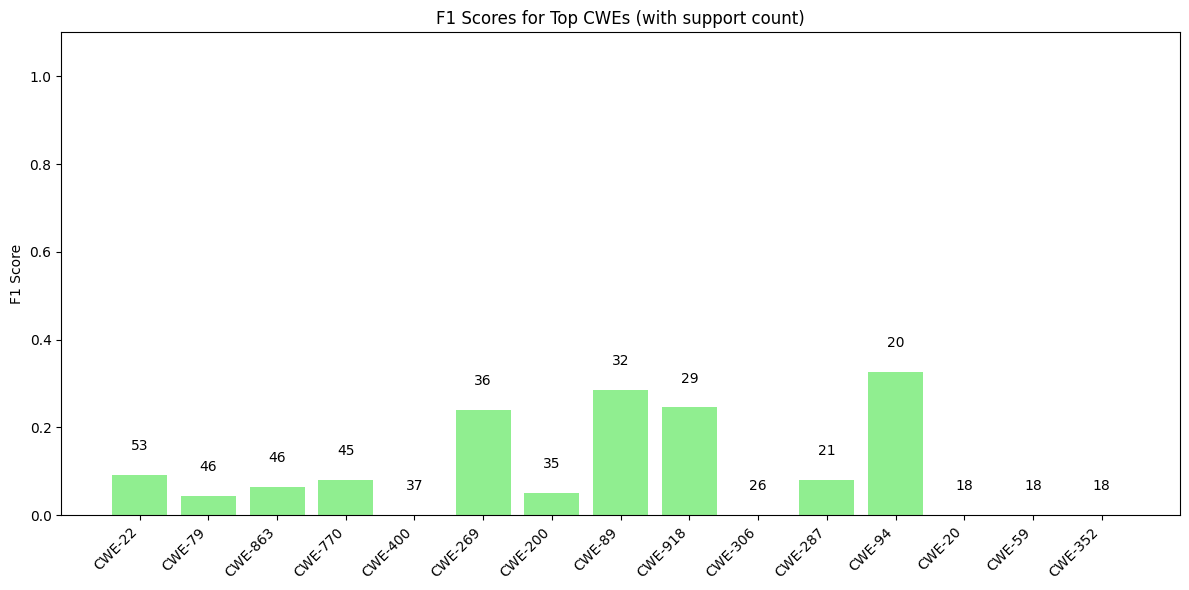

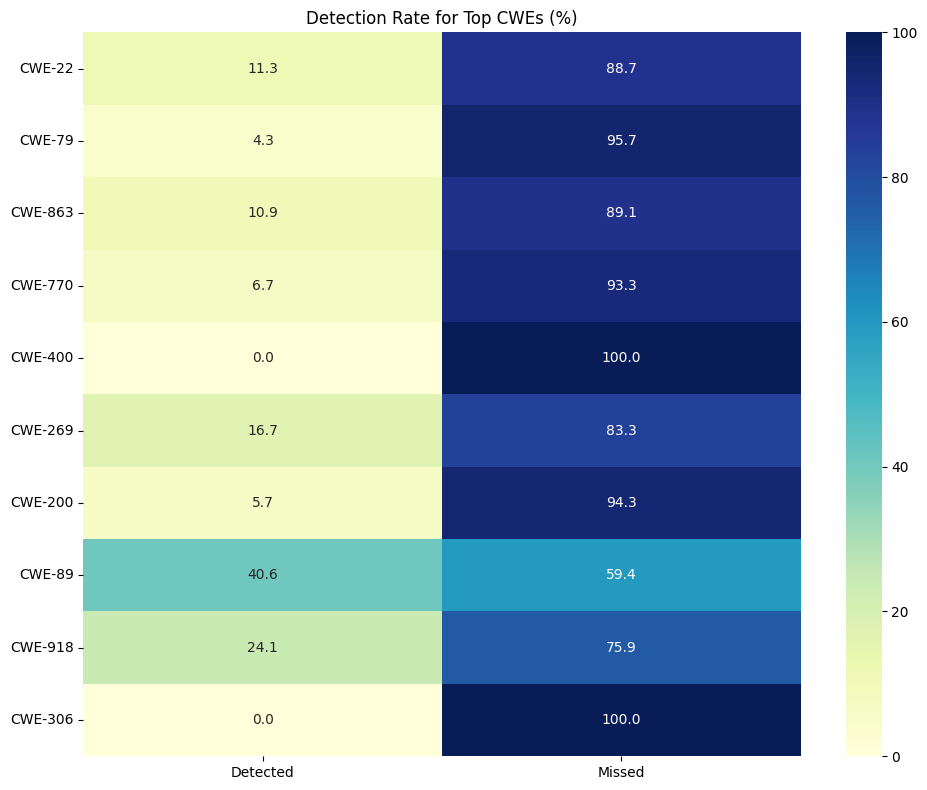

Visualization plots saved to evaluation_plots

=== EVALUATION SUMMARY ===
Total samples: 1152
Exact match rate: 0.2908
Partial match rate: 0.0035
Overall precision: 0.0941
Overall recall: 0.0899
Overall F1 score: 0.0920


In [17]:
# Cell 8: Run Metrics Generation
# Uncomment and run this cell to generate metrics from evaluation results

results_file = "evaluation_results.jsonl"
output_file = "evaluation_metrics.json"
plots_dir = "evaluation_plots"

# Option 1: If you just ran the evaluation in the notebook
# Use the results variable directly

# Option 2: Or load results from file
results = []
with open(results_file, 'r') as f:
    for line in f:
        results.append(json.loads(line))

# Calculate metrics
metrics = calculate_metrics(results)

# Save metrics to file
with open(output_file, 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"Metrics saved to {output_file}")

# Create visualizations
plots_path = create_visualizations(metrics, results, plots_dir)
print(f"Visualization plots saved to {plots_path}")

# Print summary metrics
print("\n=== EVALUATION SUMMARY ===")
print(f"Total samples: {metrics['total_samples']}")
print(f"Exact match rate: {metrics['exact_match_rate']:.4f}")
print(f"Partial match rate: {metrics['partial_match_rate']:.4f}")
print(f"Overall precision: {metrics['overall']['precision']:.4f}")
print(f"Overall recall: {metrics['overall']['recall']:.4f}")
print(f"Overall F1 score: {metrics['overall']['f1']:.4f}")

In [20]:
# Cell 9: Display Example Predictions
# Examine a few examples of model predictions

def display_example(result, index=None):
    """Display a single example with ground truth and prediction"""
    idx = index if index is not None else result["index"]
    print(f"Example #{idx}")
    print("\n=== CODE ===")
    print(result["input"][:500] + "..." if len(result["input"]) > 500 else result["input"])
    
    print("\n=== EXPECTED OUTPUT ===")
    if isinstance(result["expected_output"], list):
        print(", ".join(str(cwe) for cwe in result["expected_output"]))
    else:
        print(result["expected_output"])
    
    print("\n=== MODEL OUTPUT ===")
    print(result["model_output"][:1000] + "..." if len(result["model_output"]) > 1000 else result["model_output"])
    
    # Extract CWEs for comparison
    if isinstance(result["expected_output"], list):
        actual_cwes = []
        for cwe in result["expected_output"]:
            if isinstance(cwe, (int, str)) and str(cwe).isdigit():
                actual_cwes.append(int(cwe))
            else:
                actual_cwes.extend(extract_cwe_numbers(str(cwe)))
    else:
        actual_cwes = extract_cwe_numbers(str(result["expected_output"]))
    
    predicted_cwes = extract_cwe_numbers(result["model_output"])
    
    print("\n=== CWE COMPARISON ===")
    print(f"Expected CWEs: {actual_cwes}")
    print(f"Predicted CWEs: {predicted_cwes}")
    print(f"Correct predictions: {set(actual_cwes).intersection(set(predicted_cwes))}")
    print(f"Missed: {set(actual_cwes) - set(predicted_cwes)}")
    print(f"Extra: {set(predicted_cwes) - set(actual_cwes)}")
    print("="*50 + "\n")

# Display a few random examples
num_examples = 3
# Get three random results from the evaluation
import random
random.seed(42)  # For reproducibility
random_indices = random.sample(range(len(results)), num_examples)
for idx in random_indices:
    display_example(results[idx], index=idx)
# for i in range(len(results)):
#     display_example(results[i])

# Or display a specific example
# display_example(results[10])

Example #228

=== CODE ===
// Copyright 2015 The go-ethereum Authors
// This file is part of the go-ethereum library.
//
// The go-ethereum library is free software: you can redistribute it and/or modify
// it under the terms of the GNU Lesser General Public License as published by
// the Free Software Foundation, either version 3 of the License, or
// (at your option) any later version.
//
// The go-ethereum library is distributed in the hope that it will be useful,
// but WITHOUT ANY WARRANTY; without even the implied w...

=== EXPECTED OUTPUT ===
CWE-682

=== MODEL OUTPUT ===
CWE-770

=== CWE COMPARISON ===
Expected CWEs: [682]
Predicted CWEs: [770]
Correct predictions: set()
Missed: {682}
Extra: {770}

Example #51

=== CODE ===
package api

import (
	"github.com/grafana/grafana/pkg/util"
	"strconv"

	"github.com/grafana/grafana/pkg/bus"
	"github.com/grafana/grafana/pkg/log"
	m "github.com/grafana/grafana/pkg/models"
	"github.com/grafana/grafana/pkg/plugins"
	"github.com/grafana/gra